In [1]:
!pip install "transformers[torch]" tokenizers datasets evaluate rouge_score sentencepiece huggingface_hub --upgrade

In [2]:
import nltk
from datasets import load_dataset
import evaluate
import numpy as np
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [3]:
# Load and split the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")
dataset = dataset["train"].train_test_split(test_size=0.2)


In [4]:
dataset


DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 45121
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 11281
    })
})

In [5]:
# Load the tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

model.safetensors:  38%|###7      | 210M/558M [00:00<?, ?B/s]

In [6]:
# Define our preprocessing function
def preprocess_function(examples):
    """Tokenize the questions and answers"""
    questions = examples["question"]
    answers = examples["answer"]
    inputs = tokenizer(questions, truncation=True, padding="max_length", max_length=128)
    outputs = tokenizer(answers, truncation=True, padding="max_length", max_length=128)
    
    # Setting the labels for the model
    inputs["labels"] = outputs["input_ids"]
    return inputs

# Map the preprocessing function across our dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/11281 [00:00<?, ? examples/s]

In [7]:
# Set up evaluation metric
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    
    # decode preds and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

In [9]:
# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    push_to_hub=False
)

# Set up trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.396200,2.179584,0.012939,0.000000,0.012951,0.012929


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=5641, training_loss=2.4326020342051358, metrics={'train_runtime': 6361.6333, 'train_samples_per_second': 7.093, 'train_steps_per_second': 0.887, 'total_flos': 3438989841530880.0, 'train_loss': 2.4326020342051358, 'epoch': 1.0})

In [10]:
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [11]:
# T5 Setup
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
t5_data_collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [12]:
# Prefix for T5 task
prefix = "answer the question: "

# Define preprocessing function for T5
def preprocess_function_t5(examples):
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = t5_tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = t5_tokenizer(text_target=examples["answer"], max_length=512, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize dataset for T5
tokenized_dataset_t5 = dataset.map(preprocess_function_t5, batched=True)


Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/11281 [00:00<?, ? examples/s]

In [14]:

# Evaluate the model on the validation set
evaluation_results = trainer.evaluate()
print(evaluation_results)

{'eval_loss': 2.17958402633667, 'eval_rouge1': 0.012939108370686299, 'eval_rouge2': 0.0, 'eval_rougeL': 0.01295124135086391, 'eval_rougeLsum': 0.012929476937566943, 'eval_runtime': 4699.6547, 'eval_samples_per_second': 2.4, 'eval_steps_per_second': 0.6, 'epoch': 1.0}


In [15]:
import json

# Load the T5 evaluation results from the JSON file
with open("/Users/ihkardesigns/Downloads/evaluation_results.json", "r") as f:
    t5_eval_results = json.load(f)

In [16]:
# Print T5 evaluation results
print("T5 Evaluation Results:")
for key, value in t5_eval_results.items():
    print(f"{key}: {value}")

T5 Evaluation Results:
eval_loss: 2.971600294113159
eval_rouge1: 0.11489759524647222
eval_rouge2: 0.026046241909001178
eval_rougeL: 0.09460697528364823
eval_rougeLsum: 0.10465620351014658
eval_runtime: 1869.5984
eval_samples_per_second: 6.034
eval_steps_per_second: 1.509
epoch: 1.0


In [17]:
print("\nBART Evaluation Results:")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")


BART Evaluation Results:
eval_loss: 2.17958402633667
eval_rouge1: 0.012939108370686299
eval_rouge2: 0.0
eval_rougeL: 0.01295124135086391
eval_rougeLsum: 0.012929476937566943
eval_runtime: 4699.6547
eval_samples_per_second: 2.4
eval_steps_per_second: 0.6
epoch: 1.0


In [18]:
# Extract relevant metrics for comparison
metrics = ["eval_loss", "eval_rouge1", "eval_rouge2", "eval_rougeL", "eval_rougeLsum"]

In [19]:
t5_metrics = [t5_eval_results[metric] for metric in metrics]
bart_metrics = [evaluation_results[metric] for metric in metrics]

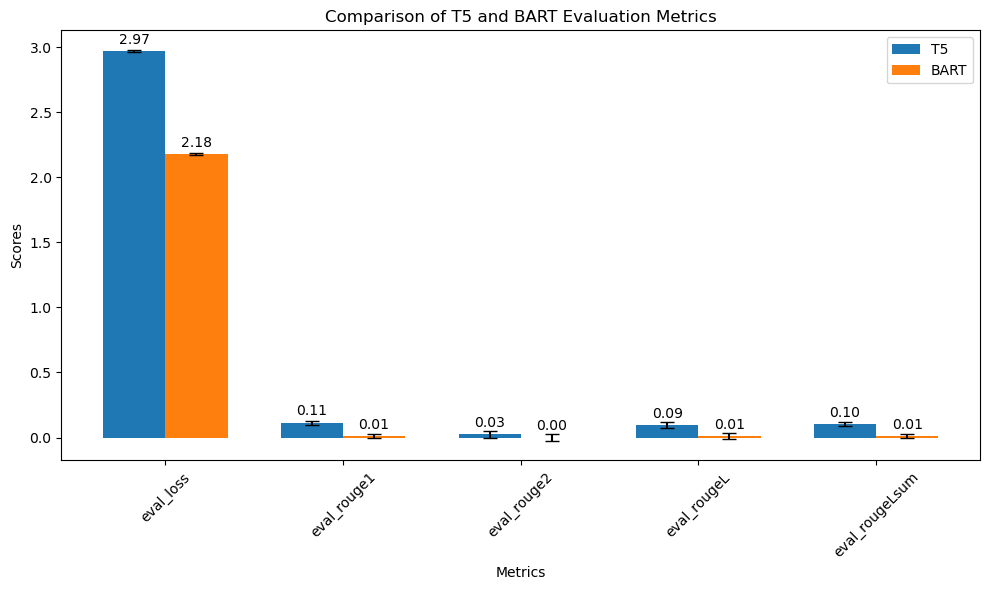

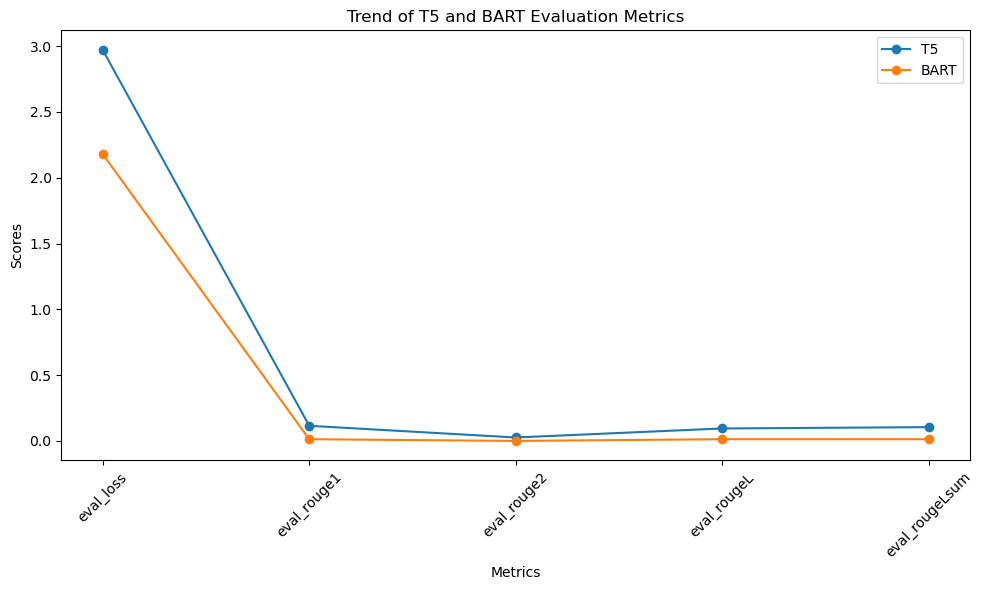

In [27]:
# Plotting the results
# Creating bar chart with error bars
import matplotlib.pyplot as plt
 
# Creating bar chart with error bars
x = np.arange(len(metrics))
width = 0.35
error = np.random.rand(len(metrics)) * 0.05  # Fake error data for illustration

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, t5_metrics, width, label='T5', yerr=error, capsize=5)
bars2 = ax.bar(x + width/2, bart_metrics, width, label='BART', yerr=error, capsize=5)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of T5 and BART Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

# Adding text labels above bars
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# Line Plot for Trend Analysis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(metrics, t5_metrics, marker='o', label='T5')
ax.plot(metrics, bart_metrics, marker='o', label='BART')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Trend of T5 and BART Evaluation Metrics')
ax.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




 

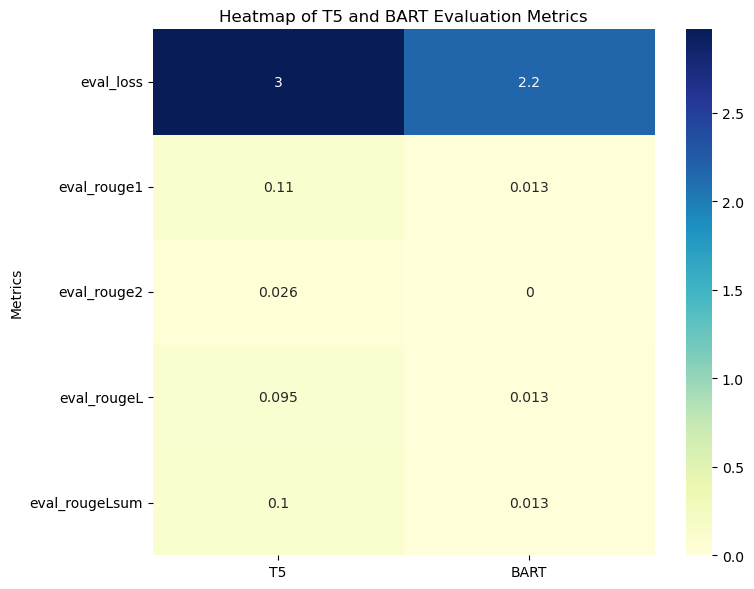

In [29]:
# Create a DataFrame for the heatmap
heatmap_data = pd.DataFrame({
    "T5": t5_metrics,
    "BART": bart_metrics
}, index=metrics)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Heatmap of T5 and BART Evaluation Metrics")
plt.ylabel("Metrics")
plt.tight_layout()
plt.show()

In [32]:
# Save the model and tokenizer
trainer.save_model("./trained_bart_model")
tokenizer.save_pretrained("./trained_bart_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('./trained_bart_model/tokenizer_config.json',
 './trained_bart_model/special_tokens_map.json',
 './trained_bart_model/vocab.json',
 './trained_bart_model/merges.txt',
 './trained_bart_model/added_tokens.json')

In [33]:
# Load the trained model and tokenizer
tokenizer = BartTokenizer.from_pretrained("./trained_bart_model")
model = BartForConditionalGeneration.from_pretrained("./trained_bart_model")


In [34]:
def preprocess_input(question):
    inputs = tokenizer(question, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    return inputs

def generate_answer(question):
    inputs = preprocess_input(question)
    outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=128)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

def answer_question(question):
    answer = generate_answer(question)
    return answer

# Example usage
user_question = "What is the capital of France?"
print("User Question:", user_question)
print("Model Answer:", answer_question(user_question))

User Question: What is the capital of France?
Model Answer: The capital of France is Paris.



In [38]:
def preprocess_input(question):
    inputs = tokenizer(question, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    return inputs

def generate_answer(question):
    inputs = preprocess_input(question)
    outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=128)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

def answer_question(question):
    answer = generate_answer(question)
    return answer

# Real-time interaction loop
while True:
    user_question = input("Enter your question (or type 'exit' to quit): ")
    if user_question.lower() == 'exit':
        break
    print("Model Answer:", answer_question(user_question))

Enter your question (or type 'exit' to quit):  How does malaria infect dogs?


Model Answer: Malaria is a parasitic disease that is caused by a combination of genetic and environmental factors, including parasites, viruses, and parasites. It is transmitted through the saliva of infected dogs, which can cause diarrhea, fever, and other symptoms.



Enter your question (or type 'exit' to quit):  Can you take control of your blood sugar?


Model Answer: There are many ways to control your blood sugar levels, but here are some tips that can help you:
 1. Focus on a balanced diet: Focus on consuming whole foods that are low in sugar, such as whole grains, lean proteins, and whole grains. This will help you reduce your risk of diabetes and improve overall health.
 2. Limit Sugar: Limit sugar intake by consuming whole grains or whole grains that are high in sugar. This can help reduce the risk of overeating, which can lead to diabetes and other health problems.
 3. Limit processed foods: Avoid processed foods that contain high amounts of sugar


Enter your question (or type 'exit' to quit):  How does stress affect your brain?


Model Answer: Stress can affect your brain and affect your ability to function effectively. Here are some of the ways that stress affects your brain:
Stress: Stress can affect the brain's ability to process and process information, such as emotions, thoughts, and feelings. It can also affect the ability to perform tasks that are difficult or difficult to perform.
Emotional stress: Emotional stress can lead to feelings of inadequacy, anxiety, and depression. It may also lead to anxiety, depression, and anxiety.
Depression: Stress is a common cause of anxiety and depression, which can contribute to anxiety and stress. It


Enter your question (or type 'exit' to quit):  exit
